# Green-Ampt infiltration model



$$ I(t) - \Delta\theta \Delta h \ln \left( 1 + \frac{I(t)}{\Delta h} \right) = K_s t $$

$$t = \frac{I(t) - \Delta\theta \Delta h \ln \left(1 + \frac{I(t)}{\Delta\theta \Delta h} \right)}{K_s}$$



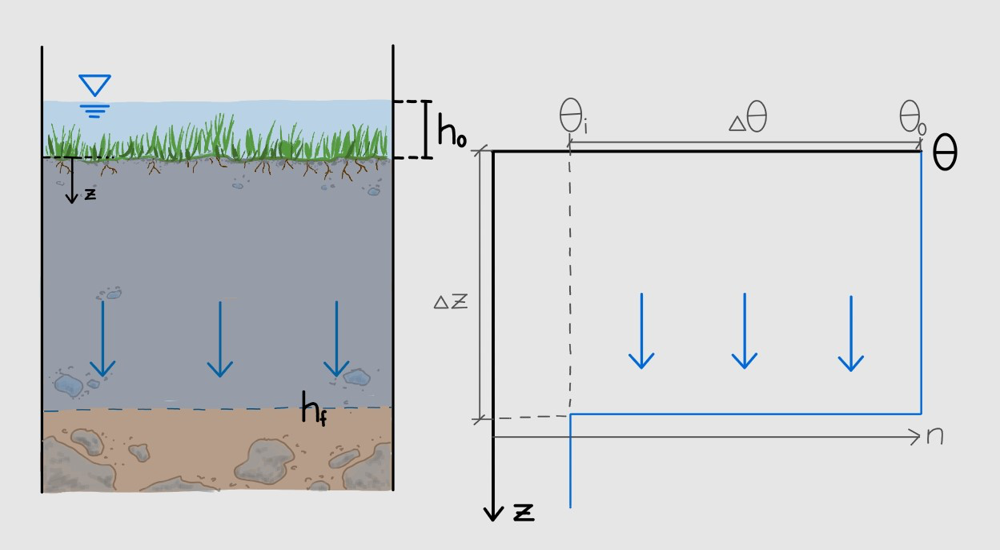

In [5]:
# Display of the image: 'GreenAmptImage.jpg' (The image must be in the same directory as the notebook)
from PIL import Image

GreenAmpt_jpg = Image.open('GreenAmptImage.jpg')
GreenAmptjpg_resize = GreenAmpt_jpg.resize((1000,550))
display(GreenAmptjpg_resize)


### Typical parameters used with the Green-Ampt model:

| USD soil-texture class | Hydraulic conductivity [mm/h] | Suction head matrix potential [mm] | Porosity [-] | Field capacity [-] | Wilting point [-] |
|------------|:--------------------------------------:|:-----------------:|:-------------:|:-------------:|:----------:|
| Sand | 120 | -49 bis -150 | 0,437 | 0,062 | 0,024 |
| lehmiger Sand | 30 | -61 bis -250 | 0,437 | 0,105 | 0,047 |
| sandiger Lehm | 11 | -110 bis -250 | 0,453 | 0,190 | 0,085 |
| Lehm | 3 | -89 bis -350 | 0,463 | 0,232 | 0,116 |
| Schluffiger Lehm | 7 | -170 | 0,501 | 0,284 | 0,135 |
| sandig-toniger Lehm | 2 | -220 | 0,398 | 0,244 | 0,136 |
| toniger Lehm | 1 | -210 | 0,464 | 0,310 | 0,187 |
| schluffig-toniger Lehm | 1 | -270 | 0,471 | 0,342 | 0,210 |
| sandiger Ton | 1 | -240 | 0,430 | 0,321 | 0,221 |
| schluffiger Ton | 1 | -290 | 0,479 | 0,371 | 0,251 |
| Ton | 0,3 | -320 bis -1000 | 0,475 | 0,378 | 0,265 |

D.A. Chin: Water-Resources Enginieering (2013)


In [6]:
# Installation of the necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact,interactive, fixed, interact_manual, Button, Layout
from IPython.display import clear_output


In [7]:
# Creating a Class with methods for calculating and visualizing infiltration according to Green-Ampt (1911)

class GreenAmptModel:                                                                   

    def __init__(self):
        '''
        Initalisierung
        '''             
        self.reference_lines = []                                                       # Initialization of parameters or lists where calculated values will be stored
        self.ref_line_params = []                                                       # The 'self' parameter refers to the current class instance, hence it can be used to accsess 
        self.short_time_ref = []                                                        # variables from outside the class 
        self.short_time_params = []                                                    
        self.infiltration_rate_ref = []
        self.infiltration_ref = []
        self.i_data = []
        self.ti_data=[]
        self.I_data=[]
        self.tI_data=[]


    def t_for_It(self, I_t, d_theta, d_h, Ks):                                                    
        '''
        Method for calculating the time intervals between individual infiltration steps.
        Parameters:
            self...Reference to the associated object
            I_t...np.array: array with infiltration values
            d_theta...Float: difference in the water content before and after infiltration
            d_h...Float: difference in the matrix potential at the wetting front and the water surface
            Ks...Float: hydraulic conductivity
        Output:
            np.array
        '''
        return (I_t - d_theta * d_h * np.log(1+ (I_t/(d_theta*d_h))))/Ks                                    

    def long_time_approximation(self, K, x):                                                          
        '''
        Methode zur Bestimmung einer Langzeitnäherung an die Infiltrationsrate
        Parameter:
            K...Float: hydraulische Durchlässigkeit
            x...np.array: x-Werte
        Ausgabe:
            Float
        '''
        it_long = np.array([K]*len(x))                                                                  
        return it_long

    def d_h(self, h0, hf):
        '''
        Method determining a long-term approximation for the infiltration rate.
        Parameters:
            K...Float: hydraulic conductivity
            x...np.array: x-values
        Output:
            Float
        '''                                                           
        return abs(hf-h0)                                                                                        

    def d_theta(self, theta_0, theta_i):
        '''
        Method determining the difference between theta_0 and theta_i.
        Parameters:
            theta_0...Float: water content before infiltration
            theta_i...Float: water content after infiltration
        Output:
            Float
        '''
        return abs(theta_0-theta_i)
    
    def infiltration_rate(self, new_t, t, I_t):
        '''
        Method calculating the infiltration rate.
        Parameters:
            new_t...np.array: time steps within the range of t
            t...np.array: time steps, as calculatet from t_for_It()
            I_t...np.array: infiltration data
        Output: np.array: infiltration rate
        '''                       
        y2 = np.interp(new_t, t, I_t)                                                                          
        i_t = np.diff(y2)
        return i_t
    
    def read_datastring(self, y_data_string='', x_data_string=''):
        '''
        Method converting a string to a list.
        Parameters:
            y_data_string, x_data_string...String: measured data in 'text format'
        Output:
            y_data, x_data...List: containig mesured data
        '''                                      
        if y_data_string and x_data_string != '':                                                   
            y_list = y_data_string.split(',')                              
            x_list = x_data_string.split(',')
            x_data = [eval(i) for i in x_list]
            y_data = [eval(i) for i in y_list]  
            return y_data, x_data


    def plot_scenario(self, I_data_string='', tI_data_string='', i_data_string='', ti_data_string='',  
                       hf_h0 = (-600,0), thetai_theta0 = (0.2,0.44), Ks=0.1):
        '''
        Plots infiltration and infiltration rate against the calculated time steps. Additionally, reference lines and imported data are displayed if available.
        Parameters:
            I_data_string, tI_data_string, i_data_string, ti_data_string...String: measured data in 'text format'
            hf_h0...Float: difference in matrix podential [mm]
            thetai_theta0: difference in soil moisture [-]
            Ks...Float: hydraulic conductivity [mm/min]
        Output:
            Plot
        '''

        # saving curent values as variables
        hf = hf_h0[0]                                                                                
        h0 = hf_h0[1]
        theta_i = thetai_theta0[0]
        theta_0 = thetai_theta0[1]
        Ks = Ks
        
        # data generation from curent values                
        delta_theta = self.d_theta(theta_0, theta_i)           
        delta_h = self.d_h(h0, hf)                                                                        
        I_t = np.arange(0.1, 1000, 0.1)                                                                    
        t = self.t_for_It(I_t, delta_theta, delta_h, Ks)                                                
        self.new_t = np.arange(round(t[0], 1), round(t[-1], 1), 0.01)                                
        self.i_t = self.infiltration_rate(self.new_t, t, I_t)                                          
        i_t_long = self.long_time_approximation(Ks, self.new_t)                                    

        # creating a figure with two subplots
        self.fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))                                       

        # plotting reference lines if required
        if self.infiltration_ref and self.ref_line_params != []:
            for ref, params in zip(self.infiltration_ref, self.ref_line_params):                   
                ref_x, ref_y = ref
                ax1.plot(ref_x, ref_y, linestyle='-.', alpha=0.6, 
                         label='I(t): hf:{}, h0:{}, theta_i:{}, theta_0:{}, Ks:{}'.format(params[0], params[1], params[2], params[3], params[4]), linewidth=2.5)
        
        if self.infiltration_rate_ref and self.ref_line_params != []:
            for ref, params in zip(self.infiltration_rate_ref, self.ref_line_params):                  
                ref_x, ref_y = ref
                ax2.plot(ref_x, ref_y, linestyle='-.', alpha=0.6,
                        label='i(t): hf:{} h0:{} theta_i:{} theta_0:{} Ks:{}'.format(params[0], params[1], params[2], params[3], params[4]), linewidth=2.5)


        # plotting infiltration data in one subplot 
        ax1.plot(t, I_t, color='black', 
                 label='I(t): hf:{}, h0:{}, theta_i:{}, theta_0:{}, Ks:{}'.format(hf, h0, theta_i, theta_0, Ks), linewidth=1)                                      
        
        ax1.set_title(label='Green-Ampt infiltration model', fontsize=20, loc= 'center')                 
        ax1.set_xlim(0, 185)
        ax1.set_xlabel('time [min]', fontsize=10)                                                         
        ax1.set_ylabel('cumulative infiltration [mm/min]', fontsize=10)
        ax1.grid(which = "major", linewidth = 1)                                                         
        ax1.grid(which = "minor", linewidth = 0.2)
        ax1.minorticks_on()
        ax1.legend(loc='best')                                                                     

        # plotting infiltration rate and hydraulic conductivity as long time approximation in the second one
        ax2.plot(self.new_t[1:-5], self.i_t[0:-5]*100, color='black',
                  label='i(t): hf:{}, h0:{}, theta_i:{}, theta_0:{}, Ks:{}'.format(hf, h0, theta_i, theta_0, Ks), linewidth=1)       
        ax2.plot(self.new_t, i_t_long, 'red', linestyle='--',                                         
                  label='Long time approximation ~ Ks [mm/min]')
                                                                                   
        ax2.set_xlim(0, 185)
        ax2.set_yscale('log')                                                                                   
        ax2.set_xlabel('time [min]', fontsize=10)                                                               
        ax2.set_ylabel('infiltration rate [mm/min]', fontsize=10)
        ax2.grid(which = "major", linewidth = 1)                                                               
        ax2.grid(which = "minor", linewidth = 0.2)
        ax2.minorticks_on()
        ax2.legend(loc='best')                                                                                  

                                                                                                       
        # If available: plot mesuremets for infiltration and/or infiltration rate.                                                                                                
        if I_data_string and tI_data_string != '':                                                              
            self.I_data, self.tI_data = self.read_datastring(I_data_string, tI_data_string)                               
            if len(self.I_data) == len(self.tI_data):                       
                ax1.scatter(self.tI_data, self.I_data, color='black', linestyle='', marker='x')                          

        if i_data_string and ti_data_string != '':                                                              
            self.i_data, self.ti_data = self.read_datastring(i_data_string, ti_data_string)                              
            if len(self.i_data) == len(self.ti_data): 
                ax2.scatter(self.ti_data, self.i_data, color='black', linestyle='', marker='x')                           
       
    def on_button_click(self, button):
        '''
        Definition for the event of a pressed button.
        Parameters:
           Button...Bool (boolean value: True or False)
        Output:
            Current infiltration data defined by sliders are saved as reference lines.
        '''

        # saving curent values as variables
        hf_val = self.hf_h0.value[0]                                                                
        h0_val = self.hf_h0.value[1]
        theta_i_val = self.thetai_theta0.value[0]
        theta_0_val = self.thetai_theta0.value[1]
        Ks_val = self.Ks_slider.value

        # data generation from curent values
        delta_theta = (self.d_theta(theta_0_val, theta_i_val))                                    
        delta_h = self.d_h(h0_val, hf_val)
        I_t = np.arange(0, 1000, 0.1)
        t = self.t_for_It(I_t, delta_theta, delta_h, Ks_val)
        self.new_t = np.arange(round(t[0], 1), round(t[-1], 1), 0.01)
        i_t = self.infiltration_rate(self.new_t, t, I_t)

        # apending current infiltration data and variables to lists 
        self.reference_lines.append((t, I_t))                                                    
        self.ref_line_params.append((h0_val, hf_val, theta_0_val, theta_i_val, Ks_val))              
        self.reference_lines.append((self.new_t, i_t))
        self.ref_line_params.append((h0_val, hf_val, theta_0_val, theta_i_val, Ks_val))
        self.infiltration_ref.append((t, I_t))
        self.infiltration_rate_ref.append((self.new_t[1:-5], self.i_t[:-5]*100))

        # display the data
        clear_output(wait=True)                                                              
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)
    

    def on_sfbutton_click(self, sf_button):
        '''
        Definition for the event of a pressed button.
        Parameters:
           Button...Bool (boolean value: True or False)
        Output:
        Green_Ampt_Infiltration.png, as file within the same folder as the notebook is located in
        '''

        self.fig.savefig('GreenAmptInfiltration.png')

        # display the current data
        clear_output(wait=True)
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)                                                                        
        

    def on_sdbutton_click(self, sd_button):
        '''
        Definition for the event of a pressed button.
        Parameters:
           Button...Bool (boolean value: True or False)
        Output:
        InfiltrationData.xlsx, as file within the same folder as the notebook is located in
        '''

        data = {'cumulative infiltration I [mm]': self.I_data,
                    'time for I [min]': self.tI_data,
                    'infiltration rate i [mm/min]': self.i_data,
                    'time for i [min]': self.ti_data
                    }
        df = pd.DataFrame(data)
        df.to_excel('InfiltrationData.xlsx', index=False)
        print("The infiltration data has successfully been writen into InfiltrationData.xlsx, you will find the file at the same location where this notebook has been saved")

        # display the current data
        clear_output(wait=True)                                                                        
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)                                                                 
    

    def create_interactive_plot(self):
        ''' 
        creating widgets to create an interactive user interface
        '''
    
        # Buttons
        self.button = Button(description="Save reference lines",                                                      
                         layout=Layout(width='20%', height='40px'), button_style='info')
        self.button.on_click(self.on_button_click)                                                                        
        
        self.sf_button = Button(description="Save Plot as Image",                                                 
                                layout=Layout(width='20%', height='40px'), button_style='info')                                            
        self.sf_button.on_click(self.on_sfbutton_click)
        

        self.sd_button = Button(description="Save input data as .xlsx",                                               
                                layout=Layout(width='20%', height='40px'), button_style='info')                                                  
        self.sd_button.on_click(self.on_sdbutton_click)
        

        # Slider
        self.hf_h0 = widgets.IntRangeSlider(                                                      
            value=[-600, 0], min=-1000, max=500, step=1,
            description=('hf - h0 [mm]'),style = {'description_width': 'initial'}
            )
        self.thetai_theta0 = widgets.FloatRangeSlider(                                            
            value=[0.1, 0.4], min=0, max=0.5, step=0.01,
            description=('theta i - theta 0 [-]'), style = {'description_width': 'initial'}
            )
        self.Ks_slider = widgets.FloatLogSlider(                                                           
            value=0.1, base = 10, min=-3, max=0.7, step=0.01,
            description='Ks [mm/min]' , style = {'description_width': 'initial'}
            )

    
        # Text input
        self.I_data_string = widgets.Textarea(                                                    
            placeholder='decimal separator: .          separator: , ',
            description='Kummulative Infiltration I [mm]', style = {'description_width': 'initial'}
            )
        
        self.tI_data_string = widgets.Textarea(
            placeholder='decimal separator: .          separator: , ',
              description='Zeitdaten für I [min]', style = {'description_width': 'initial'}
              )

        self.i_data_string = widgets.Textarea(
            placeholder='decimal separator: .          separator: , ',
              description='Infiltrationsate i [mm/min]', style = {'description_width': 'initial'}
              )
        
        self.ti_data_string = widgets.Textarea(
            placeholder='decimal separator: .          separator: , ',
              description='Zeitdaten für i [min]', style = {'description_width': 'initial'}
              )


        # linking the plot_scenario() method to the curent slider values
        self.interactive_plot = interactive(                                                             
            self.plot_scenario, 
            I_data_string=self.I_data_string, tI_data_string=self.tI_data_string, 
            i_data_string=self.i_data_string, ti_data_string=self.ti_data_string, 
            hf_h0 = self.hf_h0, thetai_theta0 = self.thetai_theta0, Ks=self.Ks_slider
            )
        
        # display the curent data
        clear_output(wait=True)
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)                                                                      


     



### User Input

In the **text** fields below, data for cumulative infiltration, infiltration rate, or the corresponding time data can be entered. To plot the data, please enter using '.' as decimal separator and ',' as the separator between individual measurement values.<br><br>

The **sliders** allow the parameters hf (matrix potential at the wetting front in mm), h0 (potential at the water surface in mm), theta 0 (soil water content after infiltration), theta i (soil water content before infiltration), and Ks (saturated hydraulic conductivity [mm/min]) to be changed for visualisation purposes.<br><br>

After pressing the **'Save reference lines' button**, the function graphs corresponding to the parameters currently set by the sliders are saved as reference lines.<br><br>

After pressing the **'Save input data as xlsx' button** measurements written into the text fields are saved in an Excel file named "Infiltration Data.xlsx" (located in the same folder as the notebook). Upon repeated activation, the "old" measurements will be overwritten.<br><br>

After pressing the **'Save Plot as Image' button'** the graph displayed in the output window is saved as "Green_Ampt_Infiltration.png" (located the same folder as the Notebook has been saved to). Upon repeated activation, the "old" graph will be overwritten.<br><br>


In [8]:
GreenAmptModel().create_interactive_plot()


interactive(children=(Textarea(value='', description='Kummulative Infiltration I [mm]', placeholder='decimal s…

Button(button_style='info', description='Save reference lines', layout=Layout(height='40px', width='20%'), sty…

Button(button_style='info', description='Save Plot as Image', layout=Layout(height='40px', width='20%'), style…

Button(button_style='info', description='Save input data as .xlsx', layout=Layout(height='40px', width='20%'),…